In [93]:
import os
import re

import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import pandas as pd
import sklearn
from sklearn import model_selection
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import scipy.linalg

(1) Pick two classes of your choice from the dataset. Train an $l_2^2$-regularized logistic regression classifier on the training set using your own fast gradient algorithm with $\lambda$ = 1. Plot, with different colors, the misclassification error on the training set and on the validation set vs iterations.

In [2]:
def list_files(dir):
    folders = []
    for root, dirs, files in os.walk(dir):
        for r in dirs:
            folders.append(r)
    return folders

def list_directories(folders_list):
    images_dirs = []
    for i in range(len(folders)):
        images_d = '/Users/jingyany/Desktop/17Spring/Data558/data competation/test two classes/'+folders[i]+'/'
        images_dirs.append(images_d)
    return images_dirs

def images_lists(images_dirs):
    list_images = []
    for i in range(len(images_dirs)):
        images_dir = images_dirs[i]
        for f in os.listdir(images_dir):
            if re.search('jpg|JPG', f):
                list_images.append(images_dir + f)
    return list_images

In [3]:
model_dir = '/Users/jingyany/models/tutorials/image/imagenet/TUTORIAL_DIR/imagenet'
dir = '/Users/jingyany/Desktop/17Spring/Data558/data competation/test two classes'
folders = list_files(dir)
images_dirs = list_directories(folders)
list_images = images_lists(images_dirs)

In [ ]:
#I pick two classes: Mockingbird and Nighthawk
#model_dir = '/Users/jingyany/models/tutorials/image/imagenet/TUTORIAL_DIR/imagenet'
#images_dir = '/Users/jingyany/Desktop/17Spring/Data558/data competation/two_classes/'
#images_dir = '/Users/jingyany/Desktop/17Spring/Data558/data competation/test two classes/091.Mockingbird/'

#list_images = [images_dir + f for f in os.listdir(images_dir) if re.search('jpg|JPG', f)]

In [4]:
def create_graph():
    with gfile.FastGFile(os.path.join(model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')


In [13]:
def extract_features(list_images):
    nb_features = 2048
    features = np.empty((len(list_images),nb_features))
    labels = []

    create_graph()

    with tf.Session() as sess:

        next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')

    for ind, image in enumerate(list_images):
        #if (ind%100 == 0):
        print('Processing %s...' % (image))
        if not gfile.Exists(image):
            tf.logging.fatal('File does not exist %s', image)

        image_data = gfile.FastGFile(image, 'rb').read()
        predictions = sess.run(next_to_last_tensor,{'DecodeJpeg/contents:0': image_data})
        features[ind,:] = np.squeeze(predictions)
        labels.append(re.split('_\d+',image.split('/')[-2].split('.')[0])[0])
    labels = list(map(int, labels))

    return features, labels


In [14]:
features,labels = extract_features(list_images)

Processing /Users/jingyany/Desktop/17Spring/Data558/data competation/test two classes/091.Mockingbird/Mockingbird_0004_81991.jpg...
Processing /Users/jingyany/Desktop/17Spring/Data558/data competation/test two classes/091.Mockingbird/Mockingbird_0006_79819.jpg...
Processing /Users/jingyany/Desktop/17Spring/Data558/data competation/test two classes/091.Mockingbird/Mockingbird_0009_81130.jpg...
Processing /Users/jingyany/Desktop/17Spring/Data558/data competation/test two classes/091.Mockingbird/Mockingbird_0010_79955.jpg...
Processing /Users/jingyany/Desktop/17Spring/Data558/data competation/test two classes/091.Mockingbird/Mockingbird_0016_79605.jpg...
Processing /Users/jingyany/Desktop/17Spring/Data558/data competation/test two classes/091.Mockingbird/Mockingbird_0018_81183.jpg...
Processing /Users/jingyany/Desktop/17Spring/Data558/data competation/test two classes/091.Mockingbird/Mockingbird_0021_80343.jpg...
Processing /Users/jingyany/Desktop/17Spring/Data558/data competation/test tw

In [16]:
pickle.dump(features, open('features', 'wb'))
pickle.dump(labels, open('labels', 'wb'))

In [17]:
features = pickle.load(open('features','rb'))
labels = pickle.load(open('labels','rb'))

In [67]:
labels = np.asarray(labels)
labels

array([91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91,
       91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 92, 92, 92, 92,
       92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92,
       92, 92, 92, 92, 92, 92, 92, 92, 92])

In [69]:
for i in range(labels.shape[0]):
    if labels[i] == 91:
        labels[i] = 1
    else:
        labels[i] = -1

In [70]:
labels

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [71]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [72]:
def computegrad(beta, lamda, x, y):
    n = len(y)
    yx = y[:, None]*x
    upper = yx*np.exp(-yx.dot(beta[:, None]))
    bottom = np.exp(-yx.dot(beta))+1
    gradient = -1/n *np.sum(upper/bottom[:, None], axis=0) + 2*lamda*beta
                            
    return gradient

In [73]:
def function(beta, lamda, x, y):
    n = len(y)
    yx = y[:, None]*x
    f = 1/n*(np.sum(np.log(np.exp(-yx.dot(beta))+1))) + lamda*np.linalg.norm(beta)**2
    return f

In [74]:
def backtracking(beta, lamda, t=1, alpha=0.5, beta_s=0.8, max_iter=100):
    grad_beta = computegrad(beta, lamda, x=X_train, y=y_train)
    norm_grad_beta = np.linalg.norm(grad_beta)
    found_t = 0 
    iter = 0 
    while (found_t == 0 and iter < max_iter):       
        if (function(beta - t*grad_beta, lamda, x=X_train, y=y_train)) < (function(beta, lamda, x=X_train, y=y_train)-alpha*t*(norm_grad_beta)**2):
            found_t = 1        
        elif(iter == max_iter):
            stop("Maximum number of iterations reached")         
        else:
            t = t*beta_s
            iter = iter + 1   
    return t 

In [84]:
def fastgradalgo(beta_init,theta,lamda,t_init, max_iter=500):
    beta = beta_init
    grad_theta = computegrad(beta, lamda, x=X_train, y=y_train)
    beta_vals = theta
    
    iter = 0
    while(iter < max_iter):         
        t = backtracking(beta, lamda)
        beta1 = theta - t*grad_theta
        theta = beta1 + t/(t+3)*(beta1 - beta)
        beta_vals = np.vstack((beta_vals, theta))
        grad_theta = computegrad(theta, lamda, x=X_train, y=y_train)
        beta = beta1
        iter = iter + 1
        
    return beta_vals

In [85]:
d = np.size(X_train, 1)
beta = np.zeros(d)
theta = np.zeros(d)
lambduh = 1
eta_init = 1/(scipy.linalg.eigh(1/len(y_train)*X_train.T.dot(X_train), eigvals=(d-1, d-1), eigvals_only=True)[0]+lambduh)
fgd_betas = fastgradalgo(beta_init=beta,theta=theta,lamda=1,t_init=eta_init)

In [86]:
def compute_misclassification_error(beta_opt, x, y):
    y_pred = 1/(1+np.exp(-x.dot(beta_opt))) > 0.5
    y_pred = y_pred*2 - 1  # Convert to +/- 1
    return np.mean(y_pred != y)

In [91]:
def plot_misclassification_error(betas_fastgrad, x_train, y_train, x_test, y_test, title=''):
    niter = np.size(betas_fastgrad, 0)
    error_train_fastgrad = np.zeros(niter)
    error_test_fastgrad = np.zeros(niter)
    for i in range(niter):
        error_train_fastgrad[i] = compute_misclassification_error(betas_fastgrad[i, :], x_train, y_train)
        error_test_fastgrad[i] = compute_misclassification_error(betas_fastgrad[i, :], x_test, y_test)
    plt.plot(range(1, niter + 1), error_train_fastgrad, c='red', label='Training set')
    plt.plot(range(1, niter + 1), error_test_fastgrad, c='blue', label='Test set')
    plt.xlabel('Iteration')
    plt.ylabel('Misclassification error')
    if title:
        plt.title(title)
    plt.legend(loc='upper right')
    plt.show()

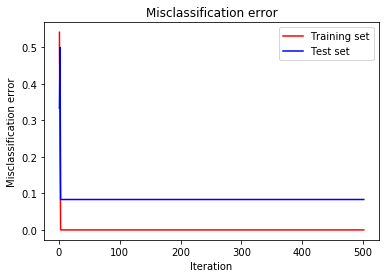

In [92]:
plot_misclassification_error(fgd_betas, X_train, y_train,X_test, y_test, title='Misclassification error')

Find the value of the regularization parameter $\lambda$ using cross-validation; you may use scikit-learn's built-in functions for this purpose. Train an $l_2^2$-regularized logistic regression classier on the training set using your own fast gradient algorithm with that value of $\lambda$ found by cross-validation. Plot, with different colors, the misclassification error on the training set and on the validation set vs iterations.

In [94]:
lr_cv = sklearn.linear_model.LogisticRegressionCV(penalty='l2', fit_intercept=False, tol=10e-8, max_iter=1000)
lr_cv.fit(X_train, y_train)
optimal_lambda = lr_cv.C_[0]
print('Optimal lambda=', optimal_lambda)

Optimal lambda= 0.00599484250319


In [95]:
d = np.size(X_train, 1)
beta = np.zeros(d)
theta = np.zeros(d)
lambduh = optimal_lambda
eta_init = 1/(scipy.linalg.eigh(1/len(y_train)*X_train.T.dot(X_train), eigvals=(d-1, d-1), eigvals_only=True)[0]+lambduh)
fgd_betas_cv = fastgradalgo(beta_init=beta,theta=theta,lamda=optimal_lambda,t_init=eta_init)

In [ ]:
plot_misclassification_error(fgd_betas, X_train, y_train,X_test, y_test, title='Misclassification error')